In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy import stats

In [21]:
from ensemble_learning import Bagging, accuracy, get_incremental_error, get_bias_variance_gse

In [3]:
# read data
cols = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df_train = pd.read_csv('../data/bank/train.csv', names=cols)
df_test  = pd.read_csv('../data/bank/test.csv', names=cols)

# process numeric input
medians = df_train.median()

for col in medians.index:
    df_train[col] = df_train[col].apply(lambda x: x > medians[col])
    df_test[col] = df_test[col].apply(lambda x: x > medians[col])
    
# process labels
label_dict={'yes': 1, 'no': -1}
df_train['y'] = df_train['y'].map(label_dict)
df_test['y'] = df_test['y'].map(label_dict)

In [4]:
tgt = 'y'

X_train = df_train.drop(tgt, axis=1).values
y_train = df_train[tgt].values

X_test = df_test.drop(tgt, axis=1).values
y_test = df_test[tgt].values

In [10]:
%%time
model = Bagging(num_trees=500)
model.fit(X_train, y_train, m=1000)

# y_pred = model.predict(X_train)
# accuracy(y_pred, y_train)

Wall time: 1min 40s


In [11]:
%%time
y_pred, t_pred = model.predict(X_train, individual=True)

error_train=[]
for i in range(t_pred.shape[1]):
    i+=1
    tp = t_pred[:, :i]
    tp = stats.mode(tp, axis=1)[0].reshape(-1)
    
    error_train.append(1 - accuracy(tp, y_train))

Wall time: 2min 28s


In [12]:
%%time
y_pred, t_pred = model.predict(X_test, individual=True)

error_test=[]
for i in range(t_pred.shape[1]):
    i+=1
    tp = t_pred[:, :i]
    tp = stats.mode(tp, axis=1)[0].reshape(-1)
    
    error_test.append(1 - accuracy(tp, y_test))

Wall time: 2min 27s


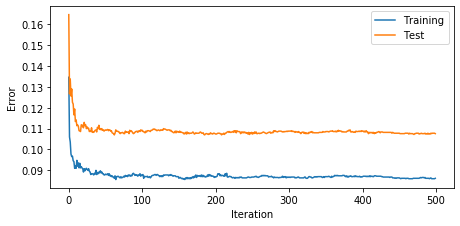

In [15]:
plt.figure(figsize=(6.5, 3.25))
plt.plot(error_train, label='Training')
plt.plot(error_test, label='Test')
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.legend()

plt.tight_layout()
# plt.savefig('p_bagging2.png', bbox_inchex='tight')

plt.show()

In [17]:
print('Bagging Results T=500')
print(f"Training Error: {round(error_train[-1], 4)}")
print(f"Test Error:     {round(error_test[-1], 4)}")

Bagging Results T=500
Training Error: 0.0862
Test Error:     0.1076


In [18]:
# %%time
# choices = np.arange(len(X_train))

# for i in range(100):
    
# #     if i % 5 == 0:
# #         print(f"beginning {i:03}")

#     # random index to subset data
#     random_idx = np.random.choice(choices, size=1000, replace=False)

#     # fit model
#     model = Bagging(num_trees=500)
#     model.fit(X_train[random_idx], y_train[random_idx])

#     # get single tree precition
#     y_pred_1 = model.trees[0].predict(X_test)

#     # get bagging prediction
#     y_pred_500 = model.predict(X_test)

#     # write results
#     results = pd.DataFrame({1: y_pred_1, 500: y_pred_500})
#     results.to_csv(f"./bagging_results/{i:03}.csv", index=False)

In [19]:
pred_1, pred_500 = [], []
files = glob.glob('./bagging_results/*.csv')

for fl in files:
    temp = pd.read_csv(fl)
    pred_1.append(temp['1'].values)
    pred_500.append(temp['500'].values)

pred_1 = np.array(pred_1)
pred_500 = np.array(pred_500)

In [22]:
bias1, var1, gse1 = get_bias_variance_gse(pred_1, y_test)
bias5, var5, gse5 = get_bias_variance_gse(pred_500, y_test)

In [23]:
dp=5
print(f"1:   Bias: {bias1.round(dp)}, Variance: {var1.round(dp)}, GSE: {gse1.round(dp)}")
print(f"500: Bias: {bias5.round(dp)}, Variance: {var5.round(dp)}, GSE: {gse5.round(dp)}")

1:   Bias: 0.33797, Variance: 0.34426, GSE: 0.68223
500: Bias: 0.34924, Variance: 0.21017, GSE: 0.55942
